In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

Using TensorFlow backend.


In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df  = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


# Exploratory Data Analysis

Text(0.5, 1.0, 'Number of Headlines per Valence Category')

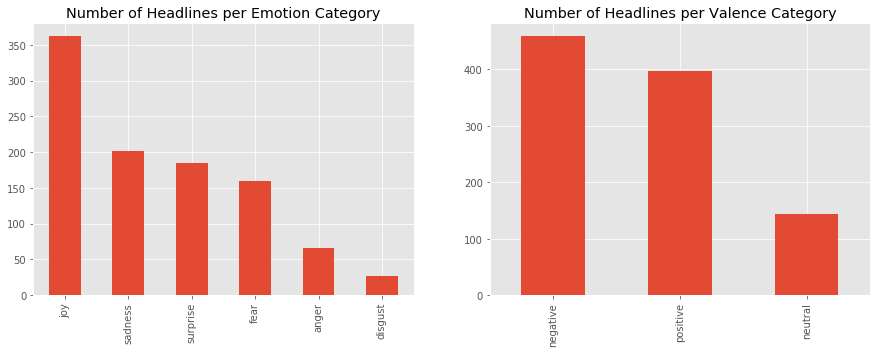

In [7]:
# bar charts showing a count of each category

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
emotion_df['max'].value_counts().plot(kind='bar')
plt.title("Number of Headlines per Emotion Category")

plt.subplot(1,2,2)
valence_df['label'].value_counts().plot(kind='bar')
plt.xticks([0,1,2], ["negative", "positive", "neutral"])
plt.title("Number of Headlines per Valence Category")


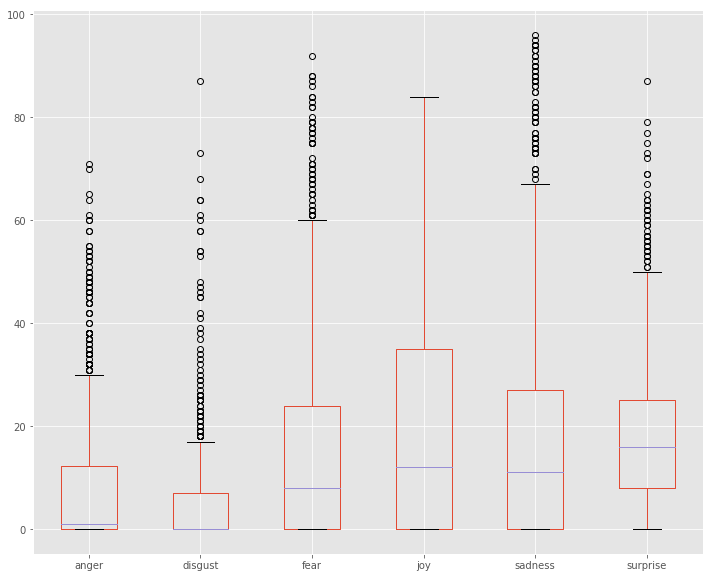

In [8]:
# boxplot showing the disribution of intensity scores for each emotion category
plt.figure(figsize=(12,10))
emotion_df.iloc[:,:-1].boxplot()

In [12]:
# note that there there are no rows with rating 0 for all emotion categories, 
# but there are 5 rows with very small values across the board (<10)
emotion_df.loc[(emotion_df.anger==0)&(emotion_df.disgust==0)&(emotion_df.fear==0)&(emotion_df.joy==0)&(emotion_df.sadness==0)& (emotion_df.surprise==0)]
emotion_df.loc[(emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)<10]
# drop these
emotion_df = emotion_df.loc[(emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)>10]
corpus_df_emotion = corpus_df.iloc[emotion_df.index]

([<matplotlib.axis.XTick at 0x1a3334ec88>],
 <a list of 1 Text xticklabel objects>)

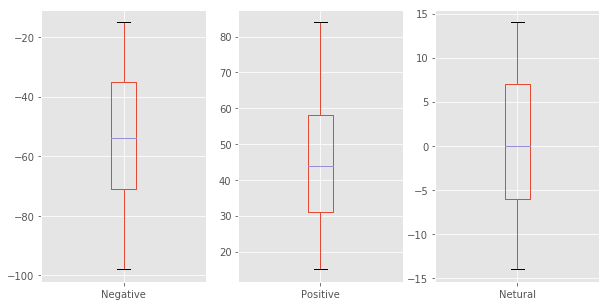

In [13]:
# boxplot showing the disribution of valencescores 
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
valence_df.loc[valence_df['label']==0]['valence'].plot(kind='box')
plt.xticks([1], labels=["Negative"])
plt.subplot(1,3,2)
valence_df.loc[valence_df['label']==1]['valence'].plot(kind='box')
plt.xticks([1], labels=["Positive"])
plt.subplot(1,3,3)
valence_df.loc[valence_df['label']==2]['valence'].plot(kind='box')
plt.xticks([1], labels=["Netural"])


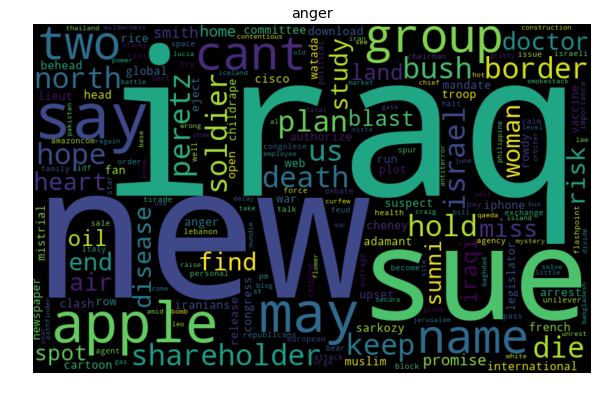

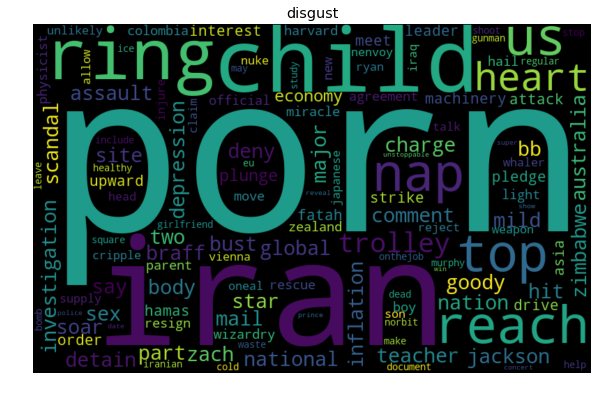

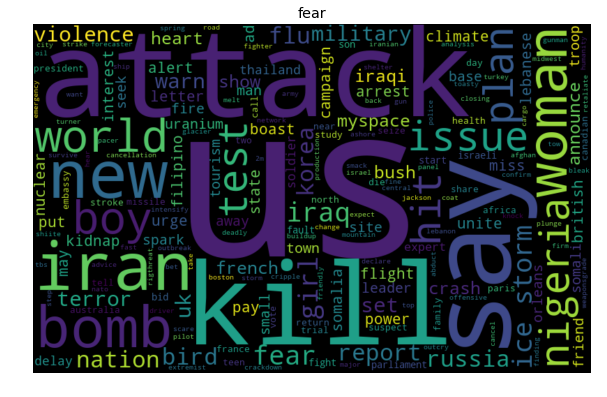

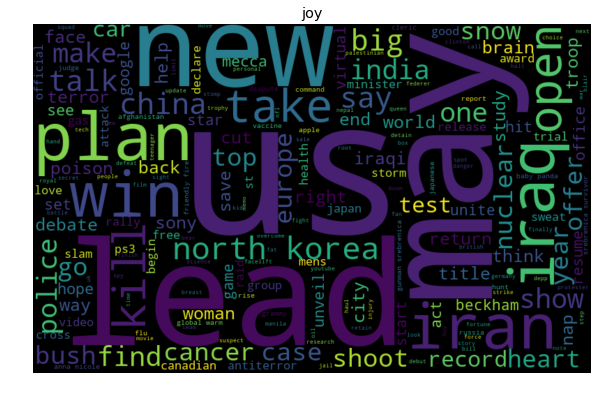

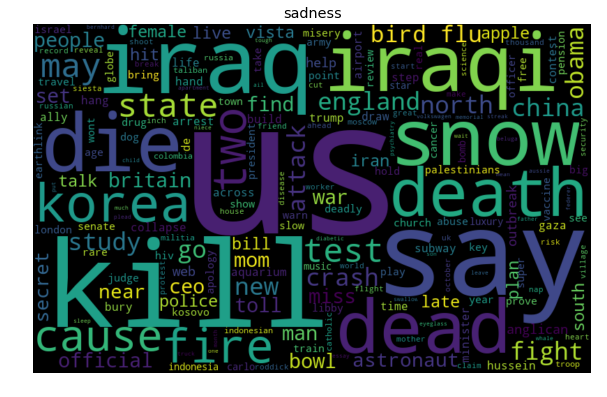

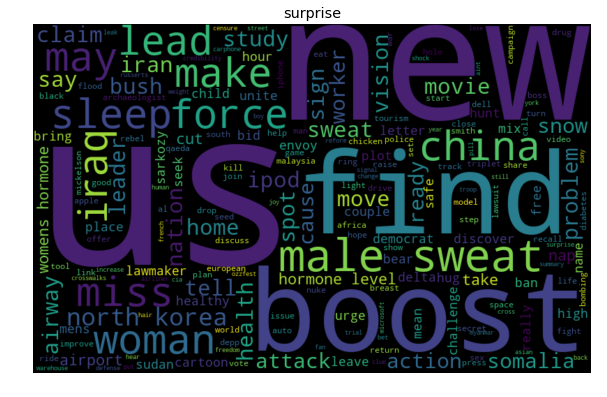

In [14]:
for i in list(emotion_df.columns[0:-2]):
    
    indexes = []
    for index, val in enumerate(emotion_df['max']):
        if val==i:
            indexes.append(index)
    
    single_emotion = corpus_df['text'][indexes] 
    word_string =' '.join([i for i in single_emotion])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    

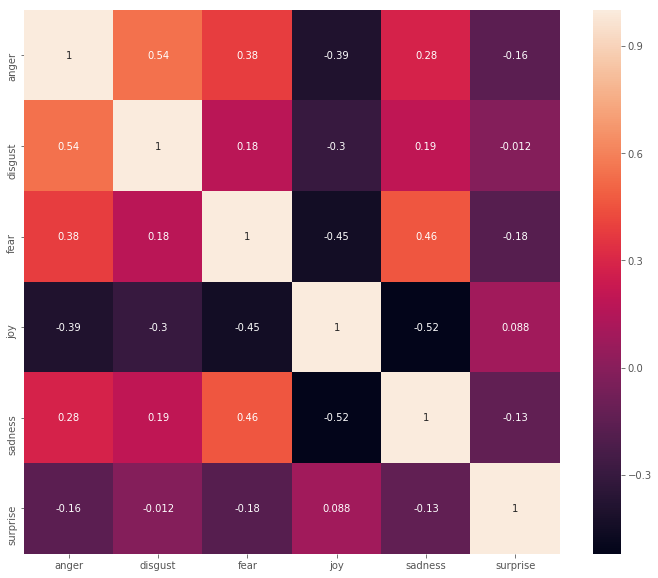

In [15]:
# correlations among emotion categories
plt.figure(figsize=(12,10))
corr = emotion_df.iloc[:,:-1].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

# Models

## Strong Pos/Neg Valence only

In [16]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['text'].iloc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [17]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape

(642, 1787)

In [18]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(688, 1787)

In [19]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9883720930232558
Training F1: 0.9883719947606372
Testing Accuracy: 0.7302325581395349
Testing F1: 0.7304900144869637


Random Forest
Training Accuracy: 0.8386627906976745
Training F1: 0.9883719947606372
Testing Accuracy: 0.6604651162790698
Testing F1: 0.6454547737713364


K Nearest Neighbors
Training Accuracy: 0.6351744186046512
Training F1: 0.5801849065135422
Testing Accuracy: 0.5720930232558139
Testing F1: 0.5339577950043066


Logistic Regression
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.6790697674418604
Testing F1: 0.6789580642566503


Text(373.36363636363626, 0.5, 'Predicted')

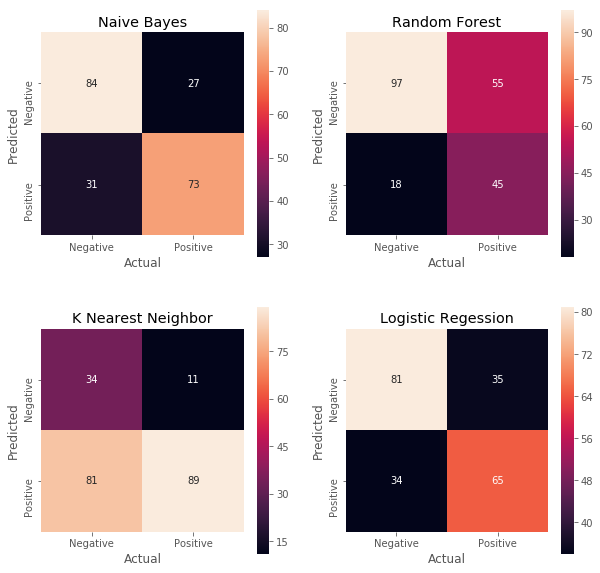

In [20]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [21]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==0) & (df.predicted==1)])

34

## All valence labels

In [22]:
X = corpus_df['text']
y = valence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [23]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2004)

In [24]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1032, 2004)

In [25]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9728682170542635
Training F1: 0.9728704556061971
Testing Accuracy: 0.556
Testing F1: 0.5722989835604799


Random Forest
Training Accuracy: 0.7403100775193798
Training F1: 0.9728704556061971
Testing Accuracy: 0.54
Testing F1: 0.4819253029928271


K Nearest Neighbors
Training Accuracy: 0.5436046511627907
Training F1: 0.507662452658841
Testing Accuracy: 0.316
Testing F1: 0.34596410504331854


Logistic Regression
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.556
Testing F1: 0.5461114660957691


Text(373.36363636363626, 0.5, 'Predicted')

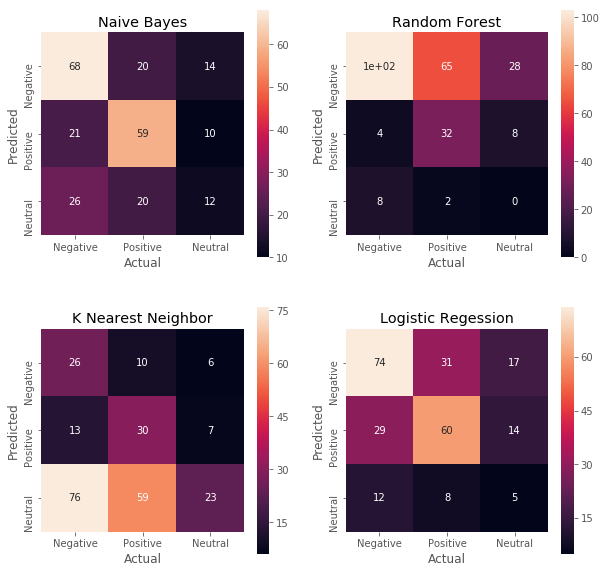

In [42]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [43]:
df = pd.DataFrame({"true": y_test, "predicted":nb_test_preds})
len(df.loc[(df.true==1) & (df.predicted==2)])

20

## Emotion categories

In [44]:
X = corpus_df_emotion['text']
y = emotion_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [45]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(746, 1979)

In [46]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1614, 1979)

In [47]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9640644361833953
Training F1: 0.9636968135107497
Testing Accuracy: 0.4497991967871486
Testing F1: 0.4607535709655403


Random Forest
Training Accuracy: 0.7874845105328376
Training F1: 0.9636968135107497
Testing Accuracy: 0.4819277108433735
Testing F1: 0.44726061813396095


K Nearest Neighbors
Training Accuracy: 0.7856257744733581
Training F1: 0.7481045045978195
Testing Accuracy: 0.3654618473895582
Testing F1: 0.3629779117206116


Logistic Regression
Training Accuracy: 0.9993804213135068
Training F1: 0.9993804191729172
Testing Accuracy: 0.4979919678714859
Testing F1: 0.4938419079210931


Text(373.36363636363626, 0.5, 'Predicted')

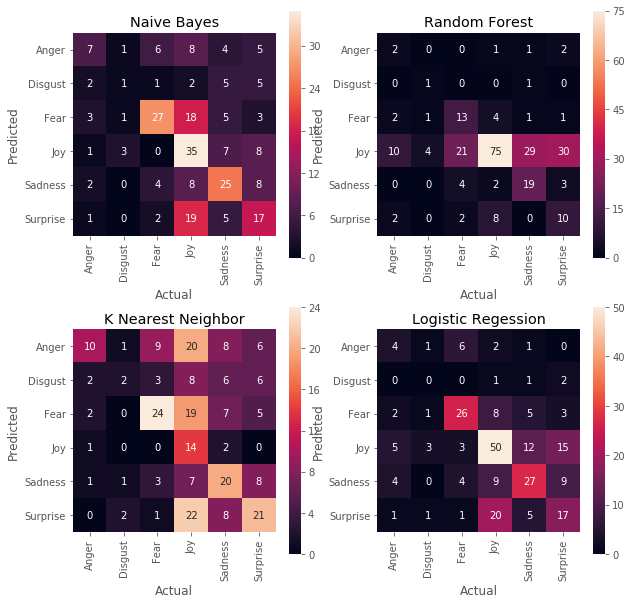

In [48]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [53]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==2) & (df.predicted==0)])

6

## Neural Network: Strong Pos/Neg Valence 

In [64]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['text'].iloc[y.index]

# from keras.utils import to_categorical
# y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res = pd.get_dummies(y_res).values

num_features = 1787
num_classes = 2

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, pd.get_dummies(y_test)))

Train on 688 samples, validate on 215 samples
Epoch 1/50
688/688 [==============================] - 2s 2ms/step - loss: 0.3657 - acc: 0.5305 - val_loss: 0.2575 - val_acc: 0.6558
Epoch 2/50
688/688 [==============================] - 0s 192us/step - loss: 0.2108 - acc: 0.7122 - val_loss: 0.2238 - val_acc: 0.6884
Epoch 3/50
688/688 [==============================] - 0s 193us/step - loss: 0.1204 - acc: 0.8416 - val_loss: 0.2238 - val_acc: 0.7023
Epoch 4/50
688/688 [==============================] - 0s 203us/step - loss: 0.0655 - acc: 0.9157 - val_loss: 0.2324 - val_acc: 0.6884
Epoch 5/50
688/688 [==============================] - 0s 187us/step - loss: 0.0381 - acc: 0.9520 - val_loss: 0.2388 - val_acc: 0.6884
Epoch 6/50
688/688 [==============================] - 0s 199us/step - loss: 0.0253 - acc: 0.9637 - val_loss: 0.2440 - val_acc: 0.6837
Epoch 7/50
688/688 [==============================] - 0s 198us/step - loss: 0.0138 - acc: 0.9855 - val_loss: 0.2451 - val_acc: 0.6837
Epoch 8/50
688/688

215/215 [==============================] - 0s 140us/step
[0.2574295393256254, 0.7162790678268255]


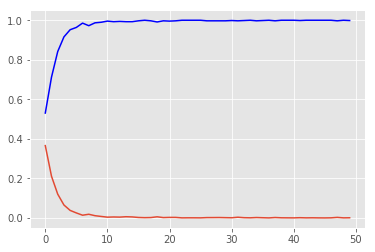

In [65]:
print(model.evaluate(tf_idf_X_test, pd.get_dummies(y_test)))

plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['loss'])

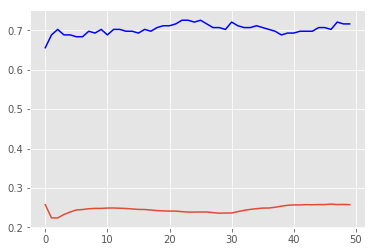

In [66]:
plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: All Valence Labels

In [68]:
X = corpus_df['text']
y = valence_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2020
num_classes = 3

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 1032 samples, validate on 250 samples
Epoch 1/50
1032/1032 [==============================] - 3s 3ms/step - loss: 0.2159 - acc: 0.5407 - val_loss: 0.2436 - val_acc: 0.4920
Epoch 2/50
1032/1032 [==============================] - 0s 267us/step - loss: 0.0402 - acc: 0.9234 - val_loss: 0.2120 - val_acc: 0.5640
Epoch 3/50
1032/1032 [==============================] - 0s 220us/step - loss: 0.0124 - acc: 0.9767 - val_loss: 0.2021 - val_acc: 0.6040
Epoch 4/50
1032/1032 [==============================] - 0s 219us/step - loss: 0.0056 - acc: 0.9903 - val_loss: 0.1940 - val_acc: 0.6400
Epoch 5/50
1032/1032 [==============================] - 0s 241us/step - loss: 0.0027 - acc: 0.9961 - val_loss: 0.1888 - val_acc: 0.6440
Epoch 6/50
1032/1032 [==============================] - 0s 208us/step - loss: 0.0022 - acc: 0.9961 - val_loss: 0.1867 - val_acc: 0.6520
Epoch 7/50
1032/1032 [==============================] - 0s 203us/step - loss: 6.9972e-04 - acc: 0.9990 - val_loss: 0.1880 - val_acc: 0.6520

250/250 [==============================] - 0s 124us/step
[0.19606052088737488, 0.644000002861023]


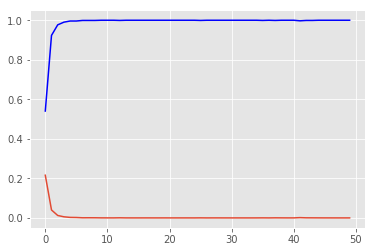

In [69]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['loss'])

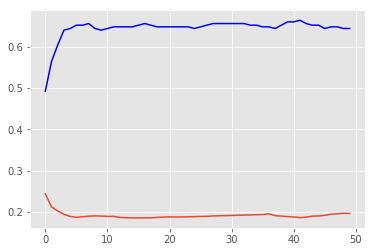

In [70]:
plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: Emotion Labels

In [71]:
X = corpus_df_emotion['text']
y = emotion_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2022
num_classes = 6

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 1614 samples, validate on 249 samples
Epoch 1/50
1614/1614 [==============================] - 2s 1ms/step - loss: 0.0995 - acc: 0.5570 - val_loss: 0.1463 - val_acc: 0.3695
Epoch 2/50
1614/1614 [==============================] - 0s 213us/step - loss: 0.0214 - acc: 0.9133 - val_loss: 0.1365 - val_acc: 0.4177
Epoch 3/50
1614/1614 [==============================] - 0s 290us/step - loss: 0.0084 - acc: 0.9709 - val_loss: 0.1330 - val_acc: 0.4498
Epoch 4/50
1614/1614 [==============================] - 0s 259us/step - loss: 0.0042 - acc: 0.9845 - val_loss: 0.1315 - val_acc: 0.4498
Epoch 5/50
1614/1614 [==============================] - 0s 245us/step - loss: 0.0023 - acc: 0.9919 - val_loss: 0.1306 - val_acc: 0.4618
Epoch 6/50
1614/1614 [==============================] - 0s 281us/step - loss: 0.0019 - acc: 0.9950 - val_loss: 0.1317 - val_acc: 0.4618
Epoch 7/50
1614/1614 [==============================] - 0s 286us/step - loss: 0.0011 - acc: 0.9969 - val_loss: 0.1314 - val_acc: 0.4418
Epo

249/249 [==============================] - 0s 131us/step
[0.1499201166462228, 0.42570280932997123]


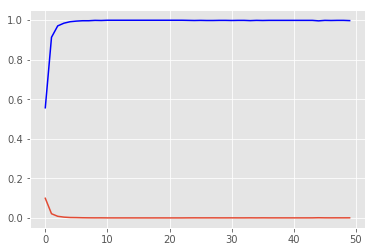

In [72]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['loss'])

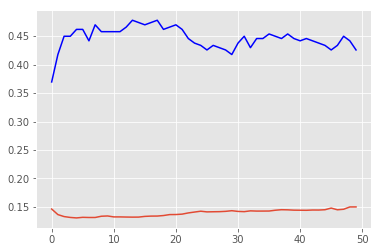

In [73]:
plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

# Metrics

In [38]:
import numpy as np

def log_loss(y_true, pred_proba):
    if y_true==1:
        return -np.log(pred_proba)
    else:
        return -np.log(1-pred_proba)
    
def log_loss_weighted(y_true, pred_proba, w=2):
    if y_true==1:
        return -w*np.log(pred_proba)
    else:
        return -np.log(1-pred_proba)

In [40]:
log_loss_weighted(1, .5, 3)

2.0794415416798357

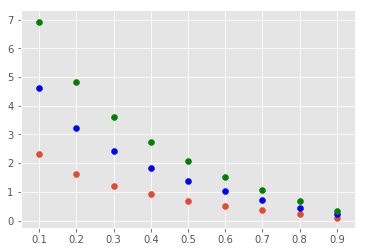

In [42]:
# http://wiki.fast.ai/index.php/Log_Loss

x = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
y = [log_loss(1,i) for i in x]
y_weighted_2 = [[log_loss_weighted(1,i) for i in x]]
y_weighted_3 = [[log_loss_weighted(1,i,3) for i in x]]

plt.scatter(x, y)
plt.scatter(x, y_weighted_2, color='blue')
plt.scatter(x, y_weighted_3, color='green')

In [45]:
stopwords = 'a,about,above,abst,accordance,according,accordingly,across,actually,added,adj,after,afterwards,again,all,almost,also,although,am,among,amongst,an,and,another,any,anybody,anyhow,anymore,anyone,anything,anyway,anyways,anywhere,apparently,approximately,are,aren,arent,arise,around,as,aside,ask,asking,at,auth,available,away,back,be,became,because,become,becomes,becoming,been,before,beforehand,begin,beginning,beginnings,begins,behind,being,believe,below,beside,besides,between,beyond,both,brief,briefly,but,by,ca,came,can,cause,causes,com,come,comes,contain,containing,contains,could,couldnt,date,did,didn\'t,do,does,doesn\'t,doing,done,don\'t,down,due,during,each,edu,effect,eg,eight,eighty,either,else,elsewhere,et,et-al,etc,even,ever,every,everybody,everyone,everything,everywhere,ex,except,far,few,fifth,first,five,followed,following,follows,for,former,formerly,forth,found,four,from,further,furthermore,go,goes,gone,got,gotten,had,happens,has,hasn\'t,have,haven\'t,having,he,hed,hence,her,here,hereafter,hereby,herein,heres,hereupon,hers,herself,hes,hi,him,himself,his,hither,how,howbeit,however,hundred,i,id,ie,if,i\'ll,im,in,inc,indeed,index,information,instead,into,invention,is,isn\'t,it,itd,it\'ll,its,itself,i\'ve,just,keep,keeps,kept,kg,km,know,known,knows,largely,last,lately,later,latter,latterly,least,less,lest,let,lets,like,liked,likely,line,little,\'ll,look,looking,looks,ltd,made,mainly,make,makes,many,may,maybe,me,mean,means,meantime,meanwhile,mg,might,million,ml,more,moreover,mostly,mr,mrs,much,must,my,myself,na,name,namely,nd,near,nearly,necessarily,neither,nine,ninety,nobody,non,none,nonetheless,noone,nor,normally,nos,noted,nothing,now,nowhere,obtain,obtained,obviously,of,off,often,oh,old,on,once,one,ones,only,onto,or,ord,other,others,otherwise,ought,our,ours,ourselves,out,outside,over,overall,own,page,pages,part,particular,past,per,perhaps,placed,plus,pp,predominantly,present,previously,primarily,probably,provides,put,que,quickly,qv,ran,rather,rd,re,recent,recently,ref,refs,regarding,regardless,related,relatively,respectively,resulted,resulting,results,run,said,same,saw,say,saying,says,sec,section,see,seeing,seem,seemed,seeming,seems,seen,self,selves,sent,seven,several,shall,she,shed,she\'ll,shes,show,showed,shown,showns,shows,similar,similarly,since,six,slightly,so,some,somebody,somehow,someone,somethan,something,sometime,sometimes,somewhat,somewhere,sorry,specifically,specified,specify,specifying,still,stop,sub,substantially,sufficiently,suggestsup,sure,take,taken,taking,tell,tends,th,than,thanx,that,that\'ll,thats,that\'ve,the,their,theirs,them,themselves,then,thence,there,thereafter,thereby,thered,therefore,therein,there\'ll,thereof,therere,theres,thereto,thereupon,there\'ve,these,they,theyd,they\'ll,theyre,they\'ve,think,this,those,thou,though,thoughh,thousand,throug,through,throughout,thru,thus,til,tip,to,together,too,took,toward,towards,tried,tries,try,trying,ts,twice,two,un,under,unfortunately,unless,unlike,unlikely,until,unto,up,upon,ups,us,use,used,usefully,usefulness,uses,using,usually,various,\'ve,via,viz,vol,vols,vs,want,wants,was,wasnt,way,we,wed,welcome,we\'ll,went,were,werent,we\'ve,what,whatever,what\'ll,whats,when,whence,whenever,where,whereafter,whereas,whereby,wherein,wheres,whereupon,wherever,whether,which,while,whither,who,whod,whoever,whole,who\'ll,whom,whomever,whos,whose,why,widely,with,within,without,wont,would,wouldnt,www,yet,you,youd,you\'ll,your,youre,yours,yourself,yourselves,you\'ve,zero'

In [46]:
stopwords.split(',')

['a',
 'about',
 'above',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'actually',
 'added',
 'adj',
 'after',
 'afterwards',
 'again',
 'all',
 'almost',
 'also',
 'although',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apparently',
 'approximately',
 'are',
 'aren',
 'arent',
 'arise',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'at',
 'auth',
 'available',
 'away',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'begin',
 'beginning',
 'beginnings',
 'begins',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'brief',
 'briefly',
 'but',
 'by',
 'ca',
 'came',
 'can',
 'cause',
 'causes',
 'com',
 'come',
 'comes',
 'contain',
 'containing',
 'contains',
 'could',
 'couldnt',
 'date',
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 '

In [82]:
import string
words = []
punct = []

for i in "This sentence@ is .inquisitive?!".split():
    if '?' in i:
        punct.append('?')
    if '!' in i:
        punct.append('!')
    i_temp = i
    for j in "~`!@#$%^&*()_-+=/\,.<>?!":
        if j in i:
            i_temp = i_temp.replace(j, '')
    words.append(i_temp)
        

' '.join(words + punct)

'This sentence is inquisitive ? !'

In [70]:
"This sentence@ is .inquisitive?!".translate(str.maketrans(', ', string.punctuation))

AttributeError: 'list' object has no attribute 'translate'